# Most *active* attacking players in World Cup 2018
Who were the players who contributed the most to the attacking actions of their teams during World Cup 2018? How did they do it? How effective they were?

To try to answer these questions I tried to run some simple analytics on the open data provided by Statsbomb.

## Definitions
Football analytics is a very broad field nowadays and many metrics exist to estimate all kinds of different attributes for a player or a team. For the purpose of this small demo, however, I chose a very simple metric to quantify the contribution of players to their teams' efforts to score. I assumed that a very active player will touch the ball very often and, if he is a very active **attacking** player, then he will probably contribute with one or more passes immediately before a shot is taken by himself or by one of his teammates. Putting in mathematical terms, in any given match I define:
* $G$ as the total number of **shots** made by player $X$'s team during the match;
* $s_{1}, s_{2}, ..., s_{G}$ as the sequence of **shots** made by player $X$'s team;
* $N$ as a time interval in seconds

For each player $X$ I define the function $p_{X}(k)$:

$\begin{equation}
    p_{X}(k) =
    \begin{cases}
      1, & \text{ if player}\ X \text{ took the shot}\ k \text{ or made a pass}\ N \text{ seconds or less before shot}\ k \\
      0, & \text{ otherwise}
    \end{cases}
\end{equation}$

The player $X$'s **activeness** can then be defined as:
$$\alpha_{X} = \sum_{k=1}^{G}{p_{k}}$$

## Goal
The goal (pun intended) is to find which player from the two finalist teams of the 2018 World Cup has been the most active, according to the definitions described above, during the whole tournament. The two teams involved are, of course, **Croatia** and **France**.

## Implementation
I start by importing some packages and defining some constants. The package FCPython, used to draw a football pitch, is taken from [here](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/FCPython.py).

In [29]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import OrderedDict
from FCPython import createPitch


# Timestamp format used in Statsbomb data
timestamp_format = '%H:%M:%S.%f'

# Size of the pitch in yards
pitchLengthX = 120
pitchWidthY = 80

# Time interval to count a pass as "recent"
interval_in_seconds = 3

# ID of the Men World Cup competition in Statsbomb data
competition_id = 43

# Name of the team we are interested in
team_name = "Croatia"

# Path of the Matches data for the competition
path = '../../../Statsbomb/data/matches/' + str(competition_id)

# Base path for the events data
events_path = '../../../Statsbomb/data/events/'

I then define a function to get the coordinates of a shot on the pitch based on the period (first half, second half). This is needed because teams switch attacking side from first to second half, but the StatsBomb data, by convention, record all coordinates as if the attack goes from left to right.

In [30]:
# Get coordinates based on the period: it means flipping the x or y coordinate from the data; this is needed because
# in Statsbomb data teams attack always from left to right
def get_coordinates(period, shot):
    if period == 1:
        x_coord = shot['location'][0]
        y_coord = pitchWidthY - shot['location'][1]
    else:
        x_coord = pitchLengthX - shot['location'][0]
        y_coord = shot['location'][1]
    return x_coord, y_coord

The following function calculates $p_{X}(k)$. The parameter $X$ is `player_name`, the argument $k$ is the shot timestamp `shot_string_timestamp` and the time interval $N$ is `seconds_interval`. 

In [31]:
def recent_pass_by_player(df_passes, shot_string_timestamp, seconds_interval, player_name):
    if df_passes is None:
        return False
    shot_timestamp = datetime.strptime(shot_string_timestamp, timestamp_format)
    passes_by_player = df_passes.loc[df_passes['player_name'] == player_name]
    for j, ball_pass in passes_by_player.iterrows():
        pass_timestamp = datetime.strptime(ball_pass['timestamp'], timestamp_format)
        if shot_timestamp > pass_timestamp:
            td = shot_timestamp - pass_timestamp
            if td.total_seconds() <= seconds_interval:
                return True
    return False

Now I collect the relevant data from the files. For every match from the team of interest, I build a DataFrame for all match events, a DataFrame for shot events only and a DataFrame for pass events only. I also build a set (i.e. a collection with unique elements) of the players that took part in the matches from the team of interest.

In [32]:
# From each file in the path, get the IDs of the matches of interest (i.e. Croatia matches)
match_ids = []
for _, _, files in os.walk(path):
    for file in files:
        with open(path + '/' + file) as data_file:
            data = json.load(data_file)
            df = pd.json_normalize(data, sep="_")
            ids = df.loc[(df['home_team_home_team_name'] == team_name) | (df['away_team_away_team_name'] ==
                                                                          team_name)]['match_id']
            match_ids.extend(ids.to_list())

# Get the event data for every match and build a list of:
# - complete DataFrames of each match;
# - DataFrame for passes only;
# - DataFrame for shots only.
match_dfs = []
match_passes_dfs = []
match_shots_dfs = []
for match_id in match_ids:
    with open(events_path + str(match_id) + '.json') as event_file:
        # Load the data as JSON
        event_data = json.load(event_file)
        # Convert JSON to DataFrame with "_" to separate nested fields
        match_df = pd.json_normalize(event_data, sep="_")
        # Save the DataFrames to the lists
        match_dfs.append(match_df.loc[match_df["team_name"] == team_name])
        match_passes_dfs.append(match_df.loc[(match_df["type_name"] == "Pass") &
                                             (match_df["team_name"] == team_name)].set_index('id'))
        match_shots_dfs.append(match_df.loc[(match_df["type_name"] == "Shot") &
                                            (match_df["team_name"] == team_name)].set_index('id'))

# Get every player for every match of the team of interest
players = set()
for match_df in match_dfs:
    # Get the team lineup for the match: it is always in the first event, since we filtered out the events for the
    # opposing team
    lineup_df = pd.json_normalize(match_df.iloc[0]['tactics_lineup'], sep="_")

    # Add every player from the lineup to the set of players
    players.update(lineup_df['player_name'].to_list())

    # Add every player that came in as a replacement in a substitution
    substitution_events = match_df.loc[match_df['substitution_replacement_name'].notnull()]

    players.update(substitution_events['substitution_replacement_name'])

# Create a dictionary from the set of players to store coordinates of their recent passes
recent_passes_dict = data = {k: [] for k in players}

Now I draw the football pitch and I add a circle to it on the location corresponing to every shot made by the team of interest (except penalties after the extra times); I make the circle red if the shot was a goal. I also add the coordinates of the shot to the dictionary `recent_passes_dict` for the players that made a pass `interval_in_seconds` seconds or less prior to the shot, i.e. for the players such that $p_{X}(k) = 1$.

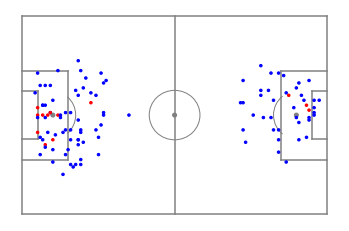

In [33]:
# Draw a football pitch
(fig, ax) = createPitch(pitchLengthX, pitchWidthY, 'yards', 'gray')

# For each DataFrame of shots
shots_count = 0
goals_count = 0
for i, match_shots in enumerate(match_shots_dfs):
    # Loop over every row of the DataFrame (i.e. every shot)
    for j, shot in match_shots.iterrows():
        # Get the period of the shot
        period = shot['period']
        # Exclude shots from penalty shootout or by the opposing team
        if period > 4:
            continue

        # Increase shots count
        shots_count += 1

        # Get the coordinates of the shot
        x_coord, y_coord = get_coordinates(period, shot)

        # Make a blue circle for every shot
        color = "blue"
        shotCircle = None

        # Make the circle red if the shot was a goal and increase goals count
        if shot['shot_outcome_name'] == "Goal":
            color = "red"
            goals_count += 1

        # Draw the circle
        shotCircle = plt.Circle((x_coord, y_coord), .5, color=color)
        # Set the circle always on top of the figure
        shotCircle.zorder = 2

        # Update recent passes for this shot
        for key in recent_passes_dict:
            # If the shot was made by the player himself, count it as a recent pass
            if shot['player_name'] == key:
                recent_passes_dict[key].append((x_coord, y_coord))
            # Otherwise, check if there was a recent pass prior to this shot
            elif recent_pass_by_player(match_passes_dfs[i], shot['timestamp'], interval_in_seconds, key):
                recent_passes_dict[key].append((x_coord, y_coord))

        # Add the circle to the figure
        if shotCircle:
            ax.add_patch(shotCircle)

The length of the list associated to each player (i.e. key) of the dictionary is the equivalent of the defined metric $\alpha_{X}$ for every player $X$. The player with the longest list is the most active attacking player according to my metric. I highlight the shots that followed a *recent* pass by the most active player with a bigger green circle.

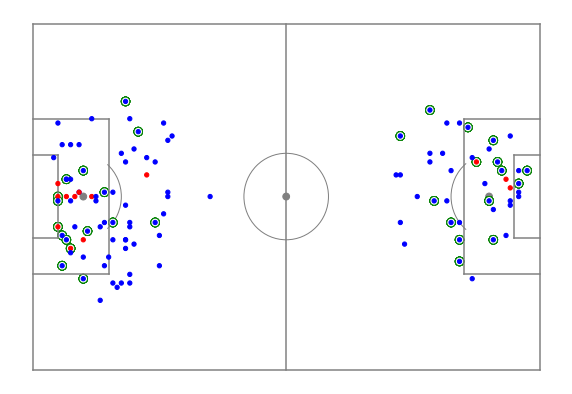

In [44]:
# Create a sorted dictionary based on the number of passes
recent_passes_ordered_dict = OrderedDict(sorted(recent_passes_dict.items(), key=lambda kv: len(kv[1]), reverse=True))

# Take the Key-Value pair of the player with most recent passes
first_player_kv = next(iter(recent_passes_ordered_dict.items()))

# Draw another circle around shots where there was a recent pass by "first_player"
for coordinates in first_player_kv[1]:
    recentPassCircle = plt.Circle((coordinates[0], coordinates[1]), 1, color="white")
    recentPassCircle.set_edgecolor("green")
    recentPassCircle.zorder = 1
    ax.add_patch(recentPassCircle)
    
fig

## Results
The analysis produced the following results for **Croatia**:

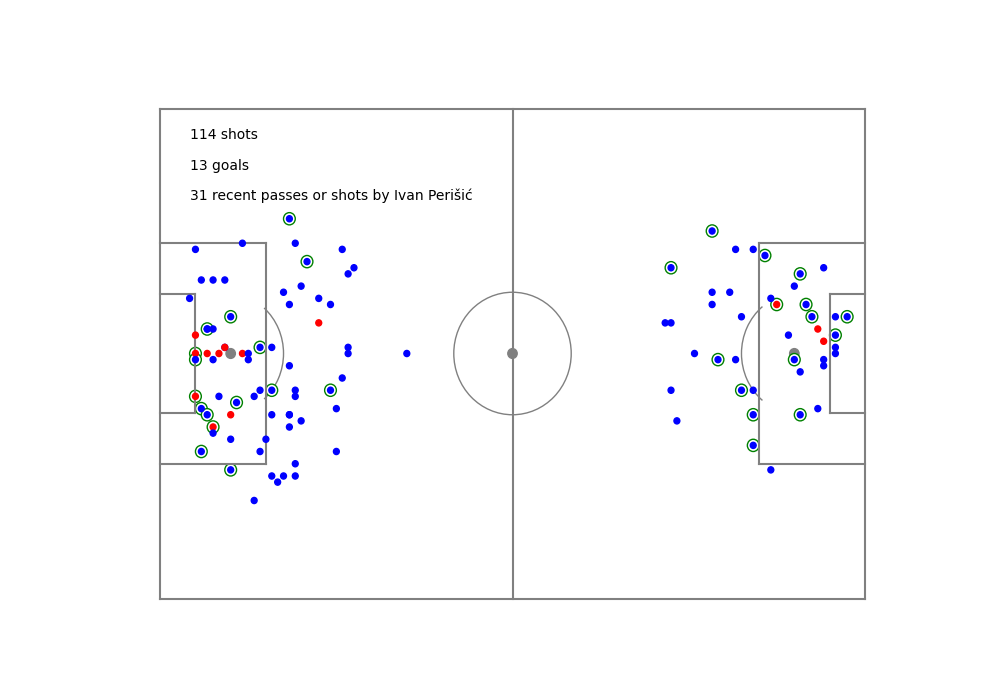](croatia_most_active_player.png "Croatia most active attacking player")

And the following results for **France**:

![France most active attacking player](france_most_active_player.png "France most active attacking player")

Not surprisingly, the most active attacking players are two of the most important strikers of their teams: **Ivan Perišić** and **Antoine Griezmann**.